주제 : 서울시 따릉이 대여량 예측 💛
- id = 고유 id
- hour = 시간
- temperature = 온도
- precipitation = 비가 오지 않았으면 0, 비가 오면 1
- windspeed = 평균 풍속
- humidity = 습도
- visibility = 시정, 시계 (특정 기상 상태에 따른 가시성을 의미)
- ozone = 오존
- pm10 = 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5 = 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count = 시간에 따른 따릉이 대여 수

# 필요한 모듈 불러오기

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as ols
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [2]:
bike_test = pd.read_csv('C:/Users/Bowon Kang/Desktop/code/sbike/sbike/test.csv')
bike_train = pd.read_csv('C:/Users/Bowon Kang/Desktop/code/sbike/sbike/train.csv')

# 데이터 확인

In [3]:
bike_train.info() 
# Dtype 확인했음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [4]:
bike_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


In [5]:
bike_test.isnull().sum()

id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [6]:
# 이름이 너무 기니까 바꾸기 
bike_train.rename( columns = {'hour_bef_temperature': 'temperature',
                             'hour_bef_precipitation':'precipitation',
                             'hour_bef_windspeed':'windspeed',
                             'hour_bef_humidity':'humidity',
                             'hour_bef_visibility':'visibility',
                             'hour_bef_ozone':'ozone',
                             'hour_bef_pm10':'pm10',
                             'hour_bef_pm2.5':'pm2.5'},inplace=True)

In [7]:
# 결측치 확인
bike_train.isnull().sum()

id                 0
hour               0
temperature        2
precipitation      2
windspeed          9
humidity           2
visibility         2
ozone             76
pm10              90
pm2.5            117
count              0
dtype: int64

In [8]:
bike_train.head(2)
# 정규화 혹은 표준화를 해줘야겠다. --> 정규분포인지 확인
# 대여수 count = 연속형 

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0


In [9]:
bike_test.head(2)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0


# 이상치 확인
--> ozone, windspeed, pm10, pm2.5에서 이상치 발견, 이상치라고 다 제거하면 안되니까 일단 놔두고 데이터분석실행

In [10]:
bike_train.describe()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


<AxesSubplot:>

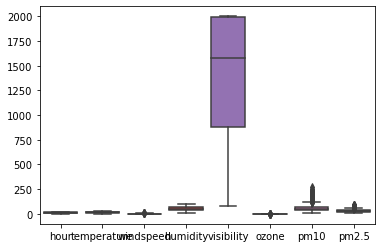

In [11]:
sns.boxplot(data=bike_train.drop(columns=['id','count','precipitation']))

<AxesSubplot:>

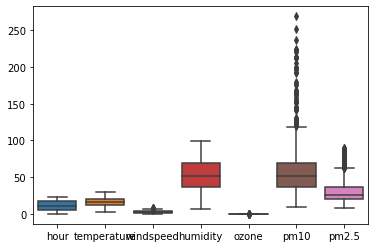

In [12]:
sns.boxplot(data=bike_train.drop(columns=['id','count','precipitation','visibility']))

<AxesSubplot:>

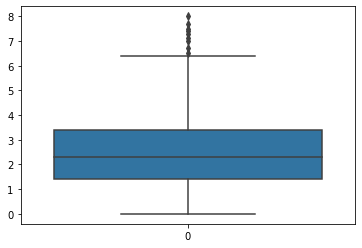

In [13]:
sns.boxplot(data=bike_train['windspeed'])

<AxesSubplot:>

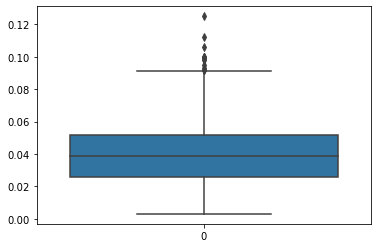

In [14]:
sns.boxplot(data=bike_train['ozone'])

# 결측치 처리
## 결측치 대체하기
- 결측치를 모두 지울것인가, 대체할 것인가?
- 결측값을 대체해주겠다 ! --> bike_train에 다시 저장해주겠다.
- 중앙값으로 대체할지, 최빈값으로 대체할지, 평균값으로 대체할지 알아보자
- 결측치 제일 많은 3개 : ozone, pm10, pm2.5 형태 확인
- 3개 다 오른쪽 꼬리를 가진 형태 -->  최빈값 > 중앙값
- 중앙값으로 처리해주겠습니다 --> 옳은 선택일까..?😭

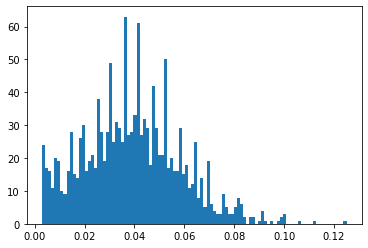

In [15]:
# 3개 다 오른쪽 꼬리를 가진 형태 -->  최빈값 > 중앙값 > 평균값
nbins = 100
plt.hist(bike_train['ozone'], bins=nbins)
plt.show()

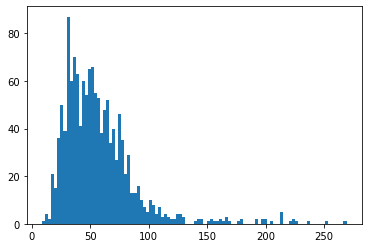

In [16]:
nbins = 100
plt.hist(bike_train['pm10'], bins=nbins)
plt.show()

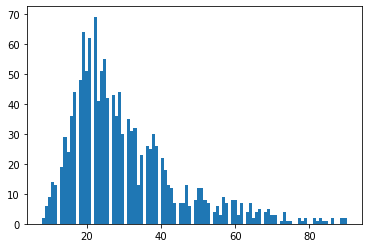

In [17]:
nbins = 100
plt.hist(bike_train['pm2.5'], bins=nbins)
plt.show()

## 결측값 대체

In [18]:
bike_train = bike_train.fillna(bike_train.median(numeric_only=True))

In [19]:
bike_train.isnull().sum() # 확인용

id               0
hour             0
temperature      0
precipitation    0
windspeed        0
humidity         0
visibility       0
ozone            0
pm10             0
pm2.5            0
count            0
dtype: int64

# 스캐일을 표준화로할 것인지, 정규화로 확인할 것인지 판단 
--> 변수 3개정도 골라서 히스토그램 그려봄 --> 정규분포아님.
--> 정규분포그림이 아니니까 min-max(정규화)로 해보겠습니다.

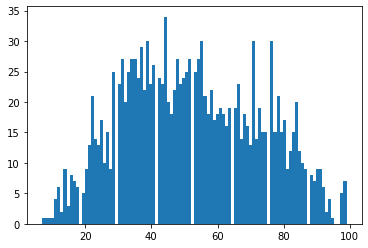

In [20]:
nbins = 100
plt.hist(bike_train['humidity'], bins=nbins)
plt.show()

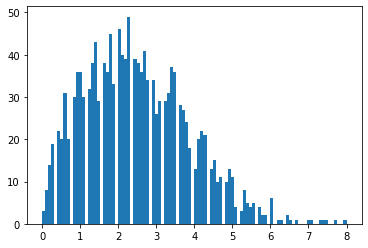

In [21]:
nbins = 100
plt.hist(bike_train['windspeed'], bins=nbins)
plt.show()

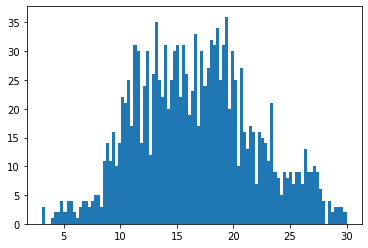

In [22]:
nbins = 100
plt.hist(bike_train['temperature'], bins=nbins)
plt.show()

# Min-max
- 주의 !!! : precipitation = 비가 오지 않았으면 0, 비가 오면 1 얘는 정규화 시키지마 !
- 주의 !! : id도 정규화하면 안됨

In [23]:
bike_train_x = bike_train.drop(columns = ['count','precipitation','id'])
bike_train_y = bike_train['count']

In [24]:
# bike_train
# target은 바꾸면 안됨. 
minmax_scale = MinMaxScaler()
minmax_scale.fit(bike_train_x)
bike_train_scaled = minmax_scale.transform(bike_train_x)

bike_train_scaled[:3]

array([[0.86956522, 0.49070632, 0.1875    , 0.89130435, 0.2591051 ,
        0.19672131, 0.25769231, 0.30487805],
       [0.56521739, 0.63197026, 0.175     , 0.44565217, 0.43600416,
        0.31967213, 0.24615385, 0.3902439 ],
       [0.26086957, 0.40148699, 0.0875    , 0.7826087 , 0.67845994,
        0.24590164, 0.08846154, 0.13414634]])

## 정규화했으니까 precipitation,id를 다시 붙인다.

In [25]:
bike_train_scaled = pd.DataFrame(bike_train_scaled, columns = ['hour','temperature','windspeed','humidity','visibility','ozone','pm10',
                                                              'pm2.5'])
bike_train_scaled.head(10)

,hour,temperature,windspeed,humidity,visibility,ozone,pm10,pm2.5
0,0.869565,0.490706,0.1875,0.891304,0.259105,0.196721,0.257692,0.304878
1,0.565217,0.631970,0.1750,0.445652,0.436004,0.319672,0.246154,0.390244
2,0.260870,0.401487,0.0875,0.782609,0.678460,0.245902,0.088462,0.134146
3,1.000000,0.185874,0.3375,0.510870,0.451613,0.303279,0.253846,0.682927
4,0.782609,0.981413,0.6000,0.000000,1.000000,0.442623,0.069231,0.036585
5,0.086957,0.390335,0.2125,0.793478,0.517690,0.196721,0.096154,0.085366
6,0.130435,0.278810,0.1875,0.554348,0.764828,0.286885,0.203846,0.304878
7,0.913043,0.479554,0.7500,0.152174,0.979709,0.385246,0.311538,0.243902
8,0.391304,0.397770,0.2375,0.619565,0.658689,0.295082,0.323077,0.134146
9,0.608696,0.524164,0.2625,0.271739,0.776795,0.180328,0.211538,0.134146


In [26]:
bike_train_new = pd.concat([bike_train_scaled,bike_train.precipitation, bike_train.id],axis=1)
bike_train_new # input값들을 이제 제대로 만든것이다.

,hour,temperature,windspeed,humidity,visibility,ozone,pm10,pm2.5,precipitation,id
0,0.869565,0.490706,0.1875,0.891304,0.259105,0.196721,0.257692,0.304878,1.0,3
1,0.565217,0.631970,0.1750,0.445652,0.436004,0.319672,0.246154,0.390244,0.0,6
2,0.260870,0.401487,0.0875,0.782609,0.678460,0.245902,0.088462,0.134146,0.0,7
3,1.000000,0.185874,0.3375,0.510870,0.451613,0.303279,0.253846,0.682927,0.0,8
4,0.782609,0.981413,0.6000,0.000000,1.000000,0.442623,0.069231,0.036585,0.0,9
...,...,...,...,...,...,...,...,...,...,...
1454,0.173913,0.509294,0.2000,0.500000,1.000000,0.229508,0.107692,0.231707,0.0,2174
1455,0.130435,0.286245,0.4750,0.413043,1.000000,0.295082,0.096154,0.134146,0.0,2175
1456,0.217391,0.565056,0.2375,0.510870,1.000000,0.049180,0.080769,0.158537,0.0,2176
1457,0.913043,0.654275,0.4625,0.326087,0.685224,0.647541,0.238462,0.341463,0.0,2178


# Train - test- split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(bike_train_new, bike_train_y, test_size=0.2, random_state=55)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1167, 10), (292, 10), (1167,), (292,))

# 선형 회귀  모델 구축 - OLS
- 결정계수, p-value, coef
-  선형성, 독립성, 정규성, 등분산성따라야함. 

In [29]:
train_target = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train, axis=1)
model_trained = model.fit()
model_trained.summary()
# 결정계수 : 0.856 모델 설명력 꽤 괜찮은듯?
# id는 고유값.
# visibility랑 pm2.5는 p-value높으니까 무시.

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['axis']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.855
Method:                 Least Squares   F-statistic:                              690.6
Date:                Sun, 06 Nov 2022   Prob (F-statistic):                        0.00
Time:                        22:25:04   Log-Likelihood:                         -6263.0
No. Observations:                1167   AIC:                                  1.255e+04
Df Residuals:                    1157   BIC:                                  1.260e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
hour            107.5747      6.021     17.865      0.000      95.760     119.389
temperature     139.9796      9.515     14.711      0.000     121.310     158.649
windspeed        40.1195     11.628      3.450      0.001      17.305      62.934
humidity        -41.8472      5.987     -6.990      0.000     -53.593     -30.101
visibility       -2.1863      5.102     -0.429      0.668     -12.196       7.823
ozone            40.1227     13.158      3.049      0.002      14.307      65.938
pm10            -83.0932     14.812     -5.610      0.000    -112.155     -54.031
pm2.5             2.1838     10.963      0.199      0.842     -19.326      23.694
precipitation   -48.3595      9.364     -5.165      0.000     -66.731     -29.988
id               -0.0018      0.002     -0.763      0.446      -0.006       0.003
==============================================================================
Omnibus:                      149.296   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.512
Skew:                           0.875   Prob(JB):                     1.97e-51
Kurtosis:                       4.319   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
model = sm.OLS(y_train, X_train.drop(['visibility', 'pm2.5'], axis = 1))
model_trained = model.fit()
print(model_trained.summary())

                                 OLS Regression Results                                
Dep. Variable:                  count   R-squared (uncentered):                   0.856
Model:                            OLS   Adj. R-squared (uncentered):              0.855
Method:                 Least Squares   F-statistic:                              864.5
Date:                Sun, 06 Nov 2022   Prob (F-statistic):                        0.00
Time:                        22:25:04   Log-Likelihood:                         -6263.1
No. Observations:                1167   AIC:                                  1.254e+04
Df Residuals:                    1159   BIC:                                  1.258e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

# heatmap
- id, precipitation 빼고 생각하기

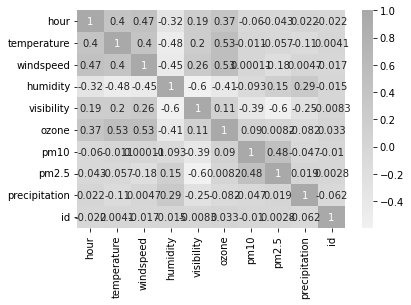

In [31]:
cmap = sns.light_palette('darkgray',as_cmap=True)
sns.heatmap(X_train.corr(), annot=True, cmap=cmap)
plt.show()

--> p-value값이 0.05가 넘는  visibility랑 pm2.5 제거하고 분석하자

#   VIF 다중공선성

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [33]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif

,VIF Factor,features
0,5.335236,hour
1,11.505776,temperature
2,7.297998,windspeed
3,4.464045,humidity
4,6.401991,visibility
5,8.272182,ozone
6,4.438453,pm10
7,5.246071,pm2.5
8,1.197675,precipitation
9,3.919891,id


--> temperature 다중공선성이 높다.

## 확률오차의 정규성 확인
- 그래프 확인결과 정규성을 따른다.

C:\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


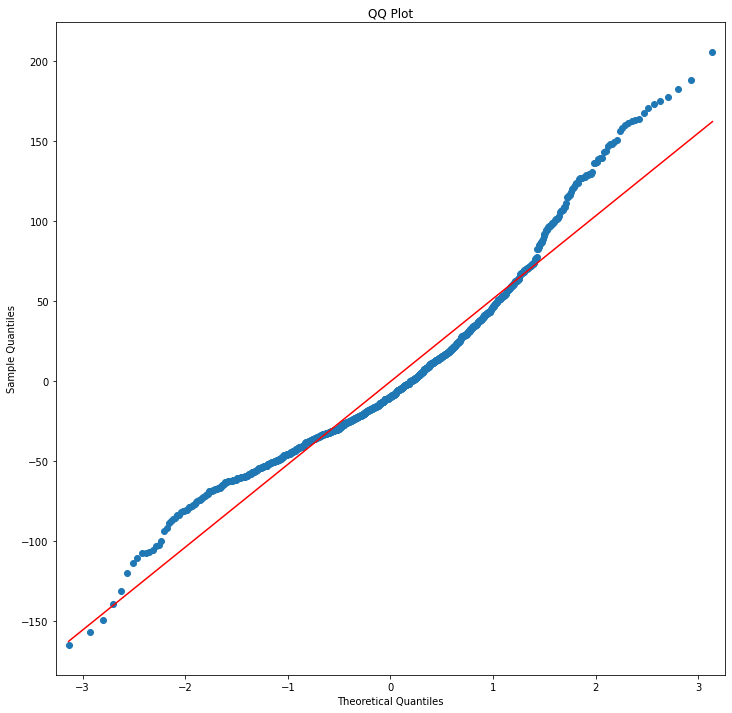

In [34]:
model_residuals = model_trained.resid

fig, ax = plt.subplots(1, 1)
fig.set_figheight(12)
fig.set_figwidth(12)
sm.ProbPlot(model_residuals).qqplot(line='s', color='#1f77b4', ax=ax)
ax.title.set_text('QQ Plot')

## 등분산성 확인
- 어느정도 따르는 듯

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Residuals vs Fitted'),
 Text(0.5, 0, 'Fitted values'),
 Text(0, 0.5, 'Residuals')]

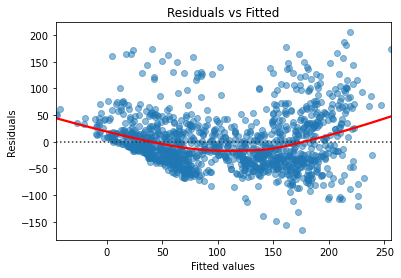

In [35]:
model_fitted_y = model_trained.fittedvalues

fig, ax = plt.subplots(1, 1)
fig.set_figheight(4)
fig.set_figwidth(6)

sns.residplot(model_fitted_y, y_train, data = X_train, lowess = True, scatter_kws = {'alpha' : 0.5}, line_kws = {'color' : 'red'}, ax = ax)
#ax.title.set_text('Residuals vs Fitted')
ax.set(title= 'Residuals vs Fitted', xlabel = 'Fitted values', ylabel = 'Residuals')

# 모든 변수값 그래프로 관계 알아보기

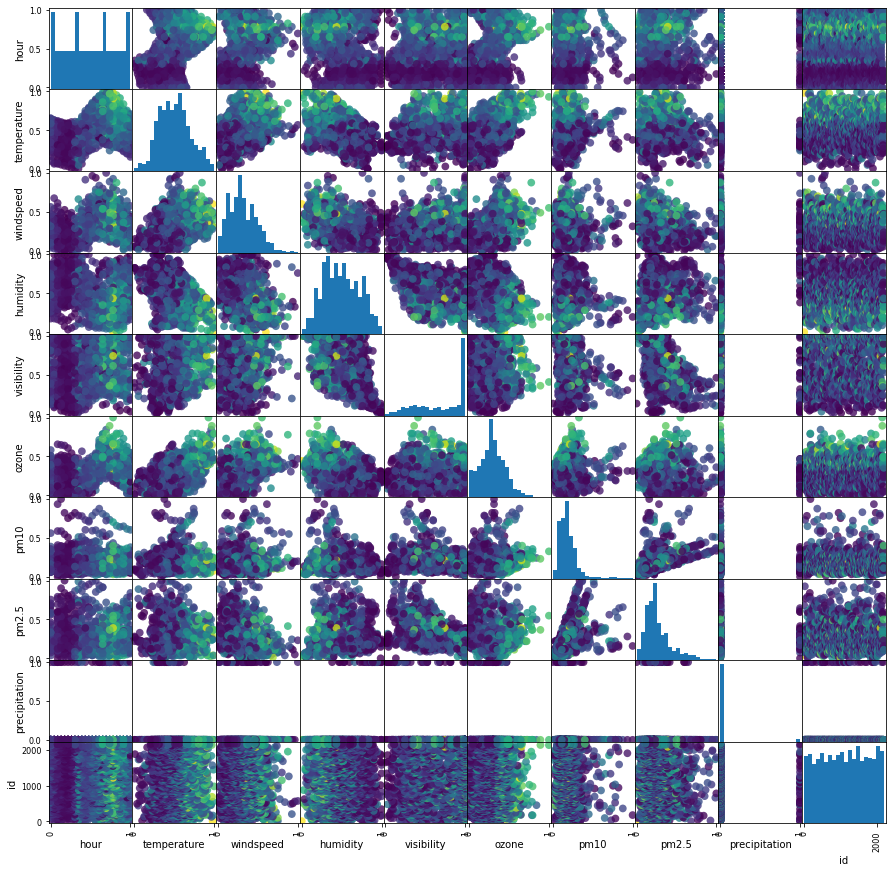

In [36]:
y1 = bike_train['count']
pd.plotting.scatter_matrix(bike_train_new, c=y1, figsize=(15, 15), marker='o', 
                           hist_kwds = {'bins':20}, s = 60, alpha=.8) 
plt.show()
# c = 색지정

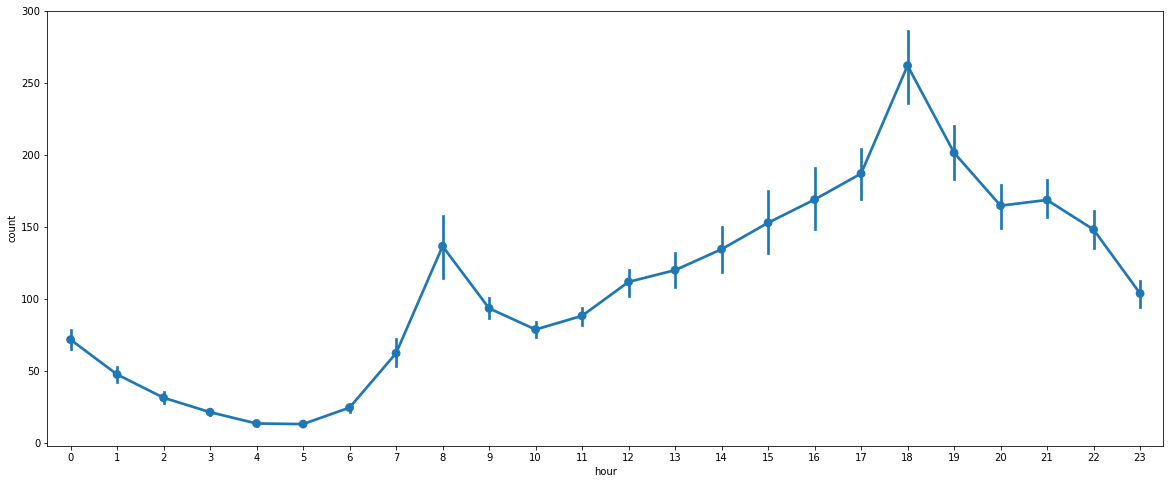

In [37]:
fig, ax = plt.subplots(figsize=(20,8))
sns.pointplot(data=bike_train, x='hour',y=y1,ax=ax)
plt.show()

--> 아침 8시, 오후 18시에 가장 대여량이 높았다.

# 다중회귀(Multiple Regression)
- --> visibility, pm2.5 (p-value)
- --> temperature (vif)
- 이 3개를 제거하고 다중회귀 실시

In [38]:
X_train_no = X_train.drop(columns=['id','visibility','pm2.5','temperature']) 
X_test_no = X_test.drop(columns=['id','visibility','pm2.5','temperature'])
# id랑 위에 3개 변수 빼주고 시작 

In [39]:
# train의 독립변수를 poly
poly = PolynomialFeatures(degree=2, include_bias = False)
poly.fit(X_train_no) # 특성을 늘린다.
train_poly = poly.transform(X_train_no)
test_poly = poly.transform(X_test_no)
train_poly.shape

(1167, 27)

In [40]:
# 선형회귀
# poly한 train의 독립변수와, train의 종속변수를 선형회귀
lr = LinearRegression()
lr.fit(train_poly, y_train)
print('train데이터 결정계수',lr.score(train_poly, y_train)) #결정계수가 0.6 --> 모델이 설명력을 가지지못한다.
print('test데이터 결정계수',lr.score(test_poly, y_test))

train데이터 결정계수 0.6047915711643228
test데이터 결정계수 0.5744579063921295


In [41]:
# degree=3으로 바꿔줌
poly = PolynomialFeatures(degree=3, include_bias = False)
poly.fit(X_train_no)
train_poly = poly.transform(X_train_no)
test_poly = poly.transform(X_test_no)
train_poly.shape
lr.fit(train_poly, y_train)
print('train데이터 결정계수',lr.score(train_poly, y_train))
print('test데이터 결정계수',lr.score(test_poly, y_test))
print('과대적합')

train데이터 결정계수 0.6886098839131176
test데이터 결정계수 0.5997883795413119
과대적합


In [42]:
# degree=5으로 바꿔줌
poly = PolynomialFeatures(degree=5, include_bias = False)
poly.fit(X_train_no)
train_poly = poly.transform(X_train_no)
test_poly = poly.transform(X_test_no)
train_poly.shape
lr.fit(train_poly, y_train)
print('train데이터 결정계수',lr.score(train_poly, y_train))
print('test데이터 결정계수',lr.score(test_poly, y_test))
print('과대적합')

train데이터 결정계수 0.7859881791767788
test데이터 결정계수 -0.15238731609828138
과대적합


--> 규제를 주기위해 ridge회귀 해보자

## ridge회귀

In [43]:
# 표준점수로 바꿔준다
ss = StandardScaler()
ss.fit(train_poly)
train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

In [44]:
ridge = Ridge()
ridge.fit(train_scaled, y_train)
print(ridge.score(train_scaled, y_train))
print(ridge.score(test_scaled, y_test))


#ridge하기전 
# train데이터 결정계수 0.6814087085838081
#test데이터 결정계수 0.6355899943209222
# --> 하기 전 보다 설명력은 좋아졌지만 여전히 과대적합 --> alpha값을 조절해보자 

0.7162095369279436
0.643697778270738


C:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


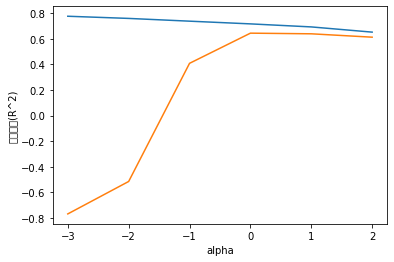

In [45]:
train_score = []
test_score = []

alpha_list =[0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alpha_list:
    # 릿지모델
    ridge = Ridge(alpha=alpha)
    # 릿지모델 훈련
    ridge.fit(train_scaled, y_train)
    # 결정계수(R2 score)
    train_score.append(ridge.score(train_scaled, y_train))
    test_score.append(ridge.score(test_scaled, y_test))
    
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('결정계수(R^2)')
plt.show()

In [46]:
ridge = Ridge(alpha=10)
ridge.fit(train_scaled, y_train)
print(ridge.score(train_scaled, y_train))
print(ridge.score(test_scaled, y_test))

0.6924772730797047
0.6386558614222875


In [47]:
ridge = Ridge(alpha=100)
ridge.fit(train_scaled, y_train)
print(ridge.score(train_scaled, y_train))
print(ridge.score(test_scaled, y_test))
# --> 이 모델이 제일 적합한 것 같다고 판단

0.6517394892110291
0.6122375081453442


# 그래프그리기

In [48]:
# ridge의 예측정도를 그래프로 나타내기
want = ridge.predict(train_scaled)
want2 = ridge.predict(test_scaled)

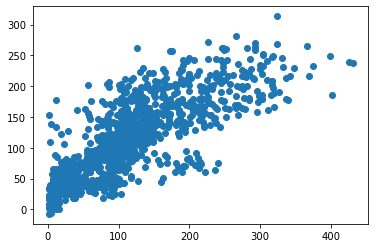

In [49]:
plt.scatter(y_train, want)
# 어느정도 잘 예측을 한 것 같다.

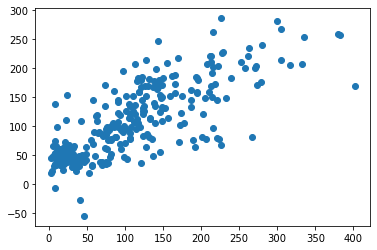

In [50]:
plt.scatter(y_test, want2)
# 예측을 잘 못한것 같다..

# 의사결정나무
--> 예측 결과가 안 좋아서 찾아보니 다중선형회귀보다는 randomforest회귀를 써야할 것으로 판단

In [136]:
from sklearn.ensemble import RandomForestRegressor
test = pd.read_csv('C:/Users/Bowon Kang/Desktop/code/sbike/sbike/test.csv')
# test파일은 target값이 없음. 
train = pd.read_csv('C:/Users/Bowon Kang/Desktop/code/sbike/sbike/train.csv')
# 헷갈려서 다시 데이터 불러왔습니다.

In [137]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [138]:
train.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [139]:
train[train['hour_bef_windspeed'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
18,33,13,22.6,0.0,NaN,41.0,987.0,0.046,64.0,39.0,208.0
244,381,1,14.1,0.0,NaN,55.0,1992.0,NaN,NaN,NaN,38.0
260,404,3,14.0,0.0,NaN,50.0,2000.0,0.049,35.0,22.0,17.0
376,570,0,14.3,0.0,NaN,49.0,2000.0,0.044,37.0,20.0,58.0
780,1196,20,16.5,0.0,NaN,31.0,2000.0,0.058,39.0,18.0,181.0
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1138,1717,12,21.4,0.0,NaN,44.0,1375.0,0.044,61.0,37.0,116.0
1229,1855,2,14.0,0.0,NaN,52.0,2000.0,0.044,37.0,20.0,20.0


In [140]:
train.groupby('hour').mean()['hour_bef_windspeed']

hour
0     1.965517
1     1.836667
2     1.633333
3     1.620000
4     1.409836
5     1.296721
6     1.331148
7     1.262295
8     1.632787
9     1.829508
10    2.122951
11    2.485246
12    2.766667
13    3.281356
14    3.522951
15    3.768852
16    3.820000
17    3.801667
18    3.838333
19    3.595082
20    3.278333
21    2.755000
22    2.498361
23    2.195082
Name: hour_bef_windspeed, dtype: float64

In [141]:
# 각 시간별 평균 값을 NA부분에 하나하나 넣어줬다.
train['hour_bef_windspeed'].fillna({18:3.281356, 244:1.836667,260:1.62, 376:1.965517,780:3.278333,934:1.965517, 1035:3.838333, 1138:2.766667, 1229:1.633333 },inplace=True)

In [143]:
# 나머지 NaN값들은 중간값으로 대체
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

## visibility, temperature, pm2.5 은 p-value값과 다중공선성으로 인해 제거하고 진행

In [144]:
feature = ['hour','hour_bef_precipitation', 'hour_bef_windspeed','hour_bef_humidity','hour_bef_ozone','hour_bef_pm10']
X_train = train[feature]
y_train= train['count']
X_test = test[feature]

In [145]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1459, 6)
(1459,)
(715, 6)


In [146]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model_1 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model_2 = RandomForestRegressor(n_estimators=200, random_state=0)
# n_estimators = 100, decision tree 100그루
# 각각의 decision tree 들의 예측값 중에 가장 예측값 높은 거 사용 하는 방식

In [147]:
# 모델 학습시키기 
model.fit(X_train, y_train)
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=0)

In [148]:
ypred0 = model.predict(X_test)
ypred1 = model_1.predict(X_test)
ypred2 = model_2.predict(X_test)

# 결과 : 따릉이 대여량 예측

In [153]:
answer = pd.DataFrame()
answer['count']=ypred0
answer['count1']=ypred1
answer['count2']=ypred2
answer
final = pd.concat([test.id,test.hour,answer],axis=1)
final.head(3)
# count는 따릉이 대여량 예측값

,id,hour,count,count1,count2
0,0,7,79.75,81.091047,83.645
1,1,17,210.23,198.686007,205.430
2,2,13,35.55,41.931450,33.710


- 아쉬운 점 
- count, count1, count2 의 예측값 중 어떤게 좋은 값인지 확인하기 위해서 RSME를 해보고싶었습니다.
- RMSE= mean_squared_error(y_actual, ypred0)**0.5 을 하고 싶었는데 test파일에 target값이 없어서
- y_actual에 어떤 값을 넣어야하는 지 몰라서 여기까지만 진행하였습니다..